In [1]:
!pip install dlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 63.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.2-cp310-cp310-linux_x86_64.whl size=3301372 sha256=a6379b0e95a9eda24b69ca9218edeabddebe9f727af3ac8e0501920fca01fe47
  Stored in directory: /root/.cache/pip/wheels/9b/e2/80/888fdc098db86b463ff0c83ae5e5ca151889e901bc1e9a3a11
Successfully built dlib


In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt  # plot
import os
from os.path import join
import dlib

import dlib # Landmarks algorithme
import math
from skimage import feature 
from skimage.feature import hog
import random
import pandas as pd

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder 


import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
import seaborn as sns 
from keras.utils import to_categorical

2024-02-29 17:11:27.138563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 17:11:27.138710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 17:11:27.337561: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
path = ('/kaggle/input/affectnet-training-data/')
file = (path + 'labels.csv')
df = pd.read_csv(file)
df.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


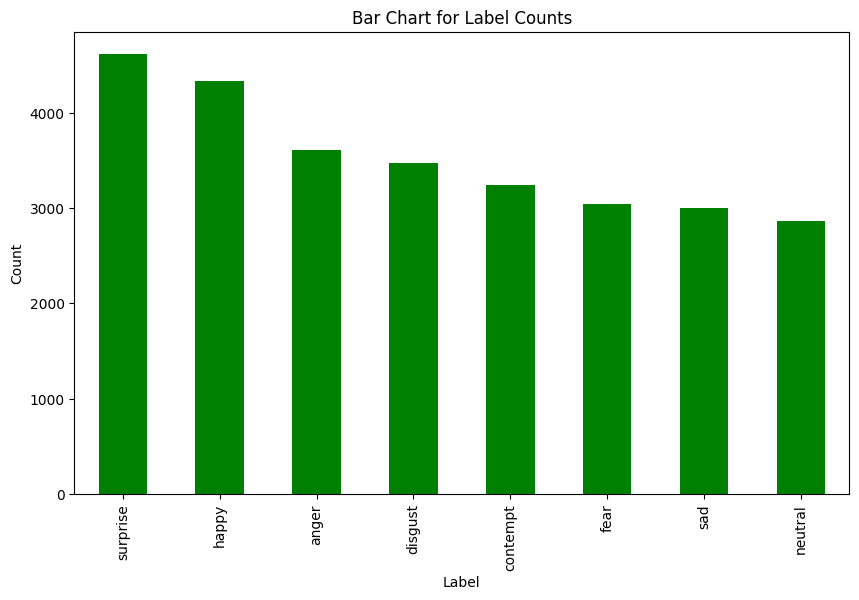

In [4]:
# Count occurrences of each label
label_counts = df['label'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='green')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Chart for Label Counts')
plt.show()

In [5]:
label_counts

label
surprise    4616
happy       4336
anger       3608
disgust     3472
contempt    3244
fear        3043
sad         2995
neutral     2861
Name: count, dtype: int64

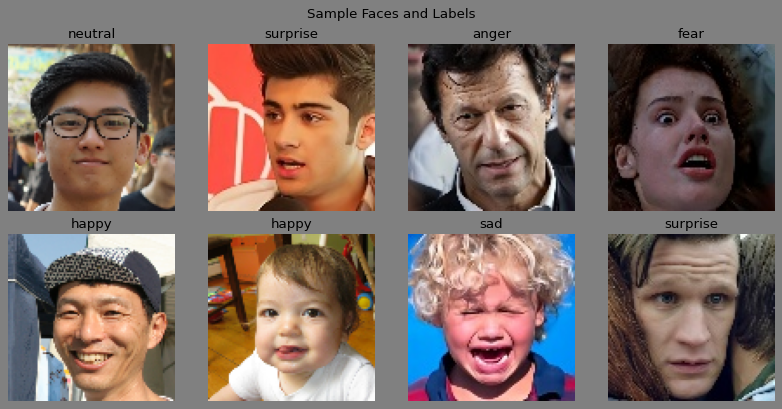

In [6]:
# display random images

import random

fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True, num=None, 
                        figsize=(10, 5), dpi=80, facecolor='gray', edgecolor='k')
fig.suptitle("Sample Faces and Labels")
axs = axs.flatten()


for i in range(8):
    idx = random.randint(0, len(df)-1)  # randomly select an index
    img_path = path + df['pth'][idx]
    img = cv2.imread(img_path)  # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
    axs[i].imshow(img)
    axs[i].set_title(df['label'][idx])
    axs[i].axis('off')

1. Data Preprocessing

In [7]:
# Extract features (image paths) and labels
X = df['pth'].values
y = df['label'].values

In [8]:
dirname='/kaggle/input/affectnet-training-data/'

In [9]:
# Extract features (image paths) and labels
X = df['pth'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
X_train.shape

(22540,)

In [11]:
np.unique(y_train)

array(['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise'], dtype=object)

In [12]:
y_train

array(['neutral', 'surprise', 'sad', ..., 'neutral', 'happy', 'contempt'],
      dtype=object)

## 1.1 Detect faces and draw landmarks with DLIP

In [14]:
def extract_facial_landmarks(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Initialize the face detector from dlib
    detector = dlib.get_frontal_face_detector()
    
    # Load the facial landmarks predictor
    predictor = dlib.shape_predictor("/kaggle/input/model/shape_predictor_68_face_landmarks.dat")
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the image
    faces = detector(gray)

    # Ensure at least one face is detected
    if len(faces) > 0:
        # Assuming the first detected face
        face = faces[0]
        
        # Get the facial landmarks
        landmarks = predictor(gray, face)
        
        # Convert landmarks to NumPy array
        landmarks_np = [(landmark.x, landmark.y) for landmark in landmarks.parts()]
        
        # Draw the landmarks on the face
#         for (x, y) in landmarks_np:
#             cv2.circle(image, (x, y), 10, (0, 255, 0), -1)
            
                # Calculate the centroid of landmarks
        centroid = np.mean(landmarks_np, axis=0, dtype=int)
        
        # Draw the central point in red
        cv2.circle(image, tuple(centroid), 25, (0, 0, 255), -1)
        
    # Display the image with landmarks and rectangles
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    return landmarks_np
        

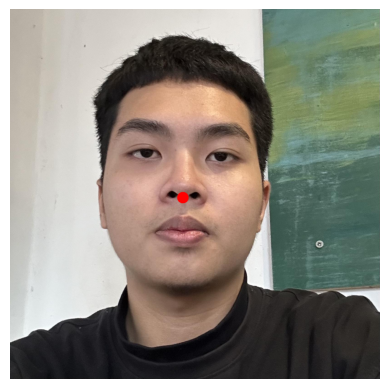

In [15]:
## visualize landmark
image_path = "/kaggle/input/img-landmark11/land_mark.jpg"
landmarks = extract_facial_landmarks(image_path)

In [ ]:
from PIL import Image

# Assuming 'image' is your image object or array
# Create a Pillow Image object if it's not already
image = Image.fromarray(your_image_array)

# Save the image to the Kaggle output directory
output_path = "/kaggle/working/your_image_name.png"
image.save(output_path)

# Optionally, display the image path
print(f"Image saved to: {output_path}")

In [7]:
def extract_feature_vectors(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Initialize the face detector from dlib
    detector = dlib.get_frontal_face_detector()
    
    # Load the facial landmarks predictor
    predictor = dlib.shape_predictor("/kaggle/input/model/shape_predictor_68_face_landmarks.dat")
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the image
    faces = detector(gray)
    
    # Ensure at least one face is detected
    if len(faces) > 0:
        # Assuming the first detected face
        face = faces[0]
        
        # Get the facial landmarks
        landmarks = predictor(gray, face)
        
        # Convert landmarks to NumPy array
        landmarks_np = np.array([[landmark.x, landmark.y] for landmark in landmarks.parts()])
        
        # Calculate the central point (mean of both axes) near the nose region
        center_point = np.mean(landmarks_np[27:36], axis=0, dtype=int)
        
        # Initialize an empty list to store the feature vectors
        feature_vectors = []
        
        # Calculate feature vectors for each facial landmark
        for point in landmarks_np:
            # Calculate the vector (magnitude and direction) between the point and the central point
            vector = np.array([point[0], point[1], np.linalg.norm(point - center_point), 
                               math.atan2(point[1] - center_point[1], point[0] - center_point[0])], dtype=float)
            
            # Append the vector to the feature vectors list
            feature_vectors.extend(vector)
        
        # Convert the feature vectors list to a NumPy array
        feature_vectors = np.array(feature_vectors).reshape(1,-1)
        
        return feature_vectors


In [ ]:
X_train

1. Get feature landmarks

In [8]:
import numpy as np
dirname='/kaggle/input/affectnet-training-data/'

def extract_features_from_images(image_paths):
    feature_vectors = []
    error = []
    error_idx = []
    for index, image_path in enumerate(image_paths):
        try:
            # Extract features from each image
            feature_vector = extract_feature_vectors(dirname + image_path)
            # Append the feature vector to the list
            if feature_vector is not None and len(feature_vector) != 0:
                feature_vectors.append(feature_vector)
            else:
                error_idx.append(index)
        except Exception as e:
            error.append(image_path)
            error_idx.append(index)
#             raise ValueError(f"Error extracting features from image at index {index}: {e}")
            continue

    
    feature_vectors = np.vstack(feature_vectors)

    output_file_path = f'/kaggle/working/error_img.txt'
    np.savetxt(output_file_path, error, fmt='%s')
    return feature_vectors, error_idx

In [ ]:
x_train_process, idx1 = extract_features_from_images(X_train[:5635])
x_train_process.shape

In [ ]:
np.save('/kaggle/working/x_train_b1.npy', x_train_process)

In [ ]:
x_test_process, idx2 = extract_features_from_images(X_test)


In [ ]:
np.save('/kaggle/working/x_test.npy', x_test_process)

In [ ]:
def y_processing(y, idx):
    mask = np.ones_like(y, dtype=bool)
    mask[idx] = False

    # Use boolean indexing to get the elements you want to keep
    y = y[mask]
    return y

y_train = y_processing(y_train[:5635], idx1)
y_test = y_processing(y_test,idx2)
label_encoder = LabelEncoder()
# Fit and transform the labels
y_train = label_encoder.fit_transform(y_train).reshape(-1,1)
y_test = label_encoder.transform(y_test).reshape(-1,1)
y_train.shape
    
    

In [ ]:
np.save('/kaggle/working/y_train_b1.npy', y_train)

In [ ]:
np.save('/kaggle/working/y_test.npy', y_test)

In [ ]:
np.save('/kaggle/working/idx_train_b1.npy', idx1)

In [ ]:
np.save('/kaggle/working/idx_test.npy', idx2)

In [ ]:
# # SVM Classifier

# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score

# svm_classifier = SVC(kernel='linear', C=1.0)
# svm_classifier.fit(x_train_process, a)
# svm_predictions = svm_classifier.predict(x_test).reshape(-1,1)
# print(svm_predictions)
# # Evaluate SVM Classifier
# svm_accuracy = accuracy_score(b, np.array(svm_predictions))
# print(f"SVM Classifier Accuracy: {svm_accuracy:.2f}")

In [ ]:
# # XGBoost Classifier
# xgb_classifier = xgb.XGBClassifier()
# xgb_classifier.fit(X_train, y_train)
# xgb_predictions = xgb_classifier.predict(X_test)

# # Evaluate XGBoost Classifier
# xgb_accuracy = accuracy_score(y_test, xgb_predictions)
# print(f"XGBoost Classifier Accuracy: {xgb_accuracy:.2f}")

## Test an image

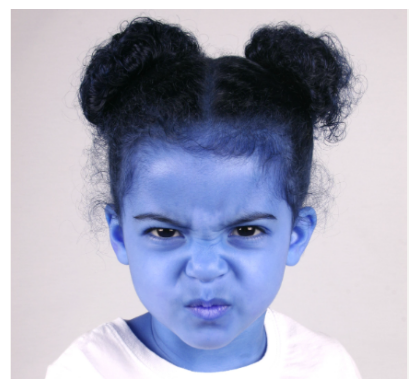

In [34]:
img = cv2.imread('/kaggle/input/data-new/test_angry.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axis labels
plt.show()

In [35]:
## processing an image
img_process = extract_feature_vectors('/kaggle/input/data-new/test_angry.png')


In [36]:
#!pip install joblib

In [37]:
## load model
import joblib
loaded_svm_model = joblib.load('/kaggle/input/svm-model-pkl/svm_model.pkl')

# Now you can use the loaded model for predictions
loaded_predictions = loaded_svm_model.predict(img_process).reshape(-1, 1)



In [39]:
label_encoder = LabelEncoder()
# Fit and transform the labels
y_train = label_encoder.fit_transform(y_train).reshape(-1,1)
y_test = label_encoder.transform(y_test).reshape(-1,1)

In [45]:
y_test = np.load('/kaggle/input/train-test-dataset/y_test.npy')

In [49]:
y_test.shape

(4402, 1)

In [48]:
# Get unique values and their counts
unique_values, counts = np.unique(y_test, return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 582
Value: 1, Count: 551
Value: 2, Count: 586
Value: 3, Count: 525
Value: 4, Count: 553
Value: 5, Count: 390
Value: 6, Count: 480
Value: 7, Count: 735


In [38]:
loaded_predictions

array([[4]])

* 0 - anger 
* 1 - contempt
* 2 - disgust
* 3 - fear
* 4 - happy
* 5 - neutral
* 6 - sad
* 7 - surprise